# Analyse Rotation Spectra - Hourly PSDS

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [4]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [5]:
# def __write_to_csv(data, text, config):
    
#     import csv
    
#     opath = config['outpath']
#     oname = config['outname']+"_"+text+"_psd.csv"
    
#     # open the file in the write mode
#     with open(opath+oname, 'w') as file:

#         writer = csv.writer(file)
#         for row in data:
#             writer.writerow(row)
            
#     if Path(opath+oname).exists():
#         print(f"created: {opath}{oname}")

In [6]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [7]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/import/kilauea-data/"

## Configurations

In [28]:
inname = "run_2022_ROMY-Z_3600_hours"
inname = "run_2019_RGRF-Z_3600_GRF"
inname = "run_2019_ROMY_ADR-Z_3600_inner"


inpath = f"{root_path}ROMY/RotationSpectra/data/{inname}/"

## load configurations
config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['save'] = False

config['inname'] = inname
config['inpath'] = inpath

config['frequency_limits'] = [0.0001, 1]



## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))


## Loading

In [29]:
def __filter_psds(psds, times, thresholds):
    
    from numpy import mean, array
    
    psds_filtered, times_filtered = [],[]
    for ii, (psd, time) in enumerate(zip(psds, times)):
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

        if thresholds[1] is not None:
            ## filter for periods between 1 and 2 seconds
            if mean(psd[640:1280] < thresholds[1]):
                ## filter for periods larger than 20 seconds
                if mean(psd[0:63]) < thresholds[0]:
                    psds_filtered.append(psd)
                    times_filtered.append(time)

        else:
            ## filter for periods larger than 20 seconds
            if mean(psd[0:63]) < thresholds[0]:
                psds_filtered.append(psd)
                times_filtered.append(time)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds")
    return array(psds_filtered), array(times_filtered)

In [30]:
def __load_data_files(config):
    
    from tqdm.notebook import tqdm
    from numpy import array
    
    config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
    config['files'].sort()

    psds_all, times = [],[]
    for file in tqdm(config['files']):

        date = file.split("_")[4][5:]
        psds_hourly = read_pickle(config['inpath']+file)
        
        for h, psd in enumerate(psds_hourly):
            psds_all.append(psd)
            times.append(int(date+str(h).rjust(2,"0")))
            
#         psds_all.append(__get_minimum_psd(psds_hourly, ff))
    return array(psds_all), times

In [31]:
psds, times = __load_data_files(config)

columns = [f.split("_")[4][5:] for f in config['files']]

## Filter

In [32]:
if "RLAS-Z" in config['inname'].split("_"):
    psds_filtered, times_filtered = __filter_psds(psds, times, [1e-21, None])
    
elif "ROMY-Z" in config['inname'].split("_"):
    psds_filtered, times_filtered = __filter_psds(psds, times, [1e-19, None])
    
elif "ROMY-V" in config['inname'].split("_"):
    psds_filtered, times_filtered = __filter_psds(psds, times, [1e-20, None])
    
elif "ROMY-U" in config['inname'].split("_"):
    psds_filtered, times_filtered = __filter_psds(psds, times, [1e-20, 4e-21])
    
elif "ROMY-W" in config['inname'].split("_"):
    psds_filtered, times_filtered = __filter_psds(psds, times, [1e-20, None])
    
else:
    psds_filtered, times_filtered = psds, times

### Write Filtered PSDS

In [33]:
# output = {"times": times_filtered, "frequencies": ff, "data": psds_filtered}

# with open(f"{inpath}{inname}psds_filtered.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)

## Plotting

In [34]:
def __makeplot_colorlines(config, ff, psds, columns):
    
    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad
    
    psds_median = __get_median_psd(array(psds))
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
    pp = zeros(len(ff))
    pp[:-1] = 1/ff[1:]
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 15

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(tqdm(psds)):
        ax.loglog(pp, psd, color=colors[n], alpha=0.7)
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


    ax.loglog(pp, psds_median, 'black', zorder=3, alpha=0.9)
#     ax.loglog(pp, psds_minimal, 'grey', zorder=2, alpha=1.0)
  
#     ax.loglog(pp, median_before, 'white', zorder=3, alpha=0.9)

    ## theoretical rlnm
    rlnm = read_csv(f"{root_path}/LNM/data/MODELS/rlnm_theory.csv")
    ax.loglog(rlnm['period'], rlnm['rlnm_psd_median'], color="grey", zorder=2, lw=2, label="RLNM")

    
    ax.set_title(f"{config['inname'].split('_')[2]} {config['inname'].split('_')[1]} ({len(psds)})", fontsize=font)

    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    ax.set_xlim(1,300)
#     ax.set_ylim(1e-26, 1e-17)
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
#     new_ticks=[]
#     for n, t in enumerate(cbar.get_ticks()):
#         print(n)
#         new_ticks.append(columns[int(t)])
#     print(new_ticks)
#     cbar.ax.set_xticklabels(columns)


    plt.show();    
    return fig

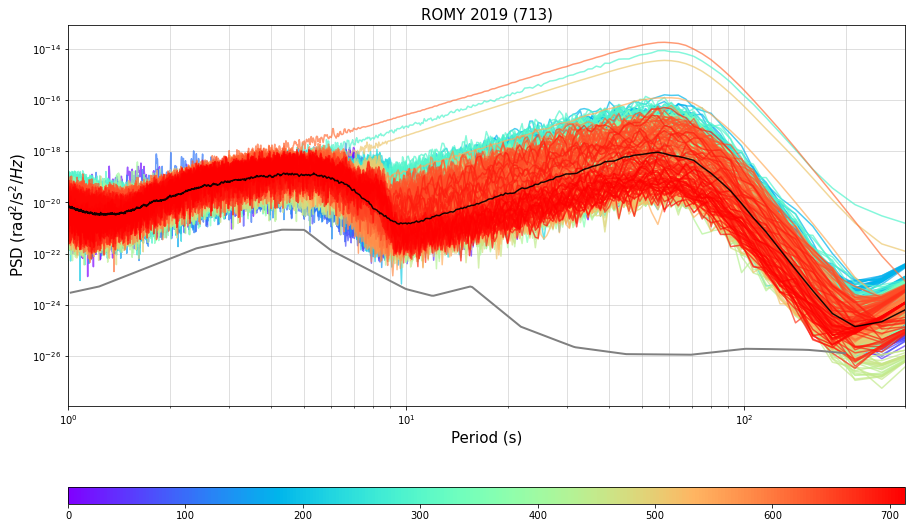

In [35]:
fig = __makeplot_colorlines(config, ff, psds_filtered, columns)

# fig.savefig("/home/brotzer/Downloads/tmp/figures/"+config['inname'].split('_')[2]+"_"+day+".png", format="png", transparent=False)


### Write to File

In [ ]:
# out = DataFrame()
# out['frequencies']  = ff
# out['psds_minimal'] = array(__get_minimal_psd(psds_filtered))
# out['psds_median']  = array(__get_median_psd(psds_filtered))

# out.to_pickle(f"{inpath}{inname}_stats.pkl")
# print(f" -> writing to {inpath}{inname}_stats.pkl")